TODO:
    
* Move print statements into a function
* Name variables well, maybe include a key at top so you don't have to keep making them over again

# Helpers

In [1]:
'''
Normalizes the standard deviation

Let coefficient of variation (CV):
CV >= 1 -> a relatively high variation
CV < 1  -> low variation
'''
def coeff_of_variation(mean, std):
    return std/mean

# Load the Datasets

We will be looking at ETH data from March 1, 2017 to November 4, 2017.

Data is taken from https://www.investing.com/currencies/eth-usd, https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory/data, and https://etherscan.io/, and https://github.com/

## Load Ether data

In [250]:
%matplotlib inline

import pandas as pd
import datetime as dt

ether_df = pd.read_csv(filepath_or_buffer='./data/ETH_DataSet.csv', sep=',')
ether_df['Date'] = pd.to_datetime(ether_df['Date'])
ether_df['Date'] = [time.date() for time in ether_df['Date']]
ether_df.head(n=5).style

,Date,Price,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocks,eth_uncles,eth_blocksize,eth_blocktime,eth_gasprice,eth_gaslimit,eth_gasused
0,2017-11-04,299.42,398758,10389337,9.55265e+07,28661.8,103567,1405.22,6196,686,12156,13.78,11624799927,6714627,21376023145
1,2017-11-03,298.4,485790,10334844,9.55063e+07,29082.6,104827,1419.28,6208,714,15831,13.68,12781813101,6716000,27474314374
2,2017-11-02,284.61,529277,10265149,9.5486e+07,27205.9,105632,1441.55,6144,795,15696,13.83,15919836477,6714869,29711567693
3,2017-11-01,289.5,527783,10170977,9.54657e+07,27629.7,109940,1505.31,6142,773,15758,13.85,14979336359,6718288,29424380755
4,2017-10-31,304.24,519906,10090762,9.54455e+07,28981.1,109012,1462.24,6275,774,15604,13.58,13692446133,6719731,29533828429


## Load Github Commit History Data

In [251]:
from pprint import pprint
import json
import os
from dateutil.parser import parse

directory_path = './data/github'

def format_date(date):
    return parse(date).strftime('%Y-%m-%d').lstrip("0").replace(" 0", " ")

def remove_time_from_commit(date):
    indexOfTimeStart = date.find('T')
    return date[0:indexOfTimeStart]

def get_commit_dict(directory_path):
    commit_dict = {};
    files = [f for f in os.scandir(directory_path) if os.path.isfile(f)]
    for f in files:
        with open(f) as data:    
            commit_history = json.load(data)
            nodes = commit_history['data']['repository']['ref']['target']['history']['edges']
            for node in nodes:
                date = format_date(remove_time_from_commit(node['node']['author']['date']))
                if date in commit_dict :
                    commit_dict[date] += 1
                else:
                    commit_dict[date] = 1
        return commit_dict
    
commit_dict = get_commit_dict(directory_path)

github_df = pd.DataFrame(list(commit_dict.items()), columns=['Date', 'Number_Commits'])
github_df['Date'] = pd.to_datetime(github_df['Date'])
github_df['Date'] = [time.date() for time in github_df['Date']]
github_df.head(n=5).style

,Date,Number_Commits
0,2017-11-02,2
1,2017-10-31,1
2,2017-10-29,2
3,2017-10-28,2
4,2017-10-27,2


## Combine the Ether Data and Commit History DataFrames

In [252]:
df = ether_df.merge(github_df, on='Date', how='left').fillna(0)
df.head(n=5).style

columns = df.columns
index = df.index

# Split DataFrame into data X and class labels y

In [253]:
X = df.drop('Price', axis=1)
y = df['Price']

# Data Exploration

TODO:
Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)

In [254]:
X.head(n=5).style

,Date,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocks,eth_uncles,eth_blocksize,eth_blocktime,eth_gasprice,eth_gaslimit,eth_gasused,Number_Commits
0,2017-11-04,398758,10389337,9.55265e+07,28661.8,103567,1405.22,6196,686,12156,13.78,11624799927,6714627,21376023145,0
1,2017-11-03,485790,10334844,9.55063e+07,29082.6,104827,1419.28,6208,714,15831,13.68,12781813101,6716000,27474314374,0
2,2017-11-02,529277,10265149,9.5486e+07,27205.9,105632,1441.55,6144,795,15696,13.83,15919836477,6714869,29711567693,2
3,2017-11-01,527783,10170977,9.54657e+07,27629.7,109940,1505.31,6142,773,15758,13.85,14979336359,6718288,29424380755,0
4,2017-10-31,519906,10090762,9.54455e+07,28981.1,109012,1462.24,6275,774,15604,13.58,13692446133,6719731,29533828429,1


These are the 5 most recent Ethereum data points. There's a large disparity in value for these features, so normalizing the data points by taking the natural log of them is necessary, so that one feature does not outweigh the others just because of its magnitude.

In [255]:
y.head(n=5)

0    299.42
1    298.40
2    284.61
3    289.50
4    304.24
Name: Price, dtype: float64

These are the 5 most recent prices of Ether.

In [256]:
X.shape

(249, 15)

There are **249** data points and **15** features. The large number of features and small number of data points does present a problem for the predictions. I want to reduce my feature size, so my model does not suffer from the curse of dimensionality, i.e. as the number of features grows, the number of data points the model needs to properly train grows exponentially.

### Statistics on ether transactions 

I will focus on these 3 features: 

* ether transactions (eth_tx)
* ether gas price (eth_gasprice)
* number of aggregated github commits on the top 3 ethereum repositories (Number_Commits)

In [257]:
print("Ether Transactions:")
print(X['eth_tx'].describe())

print("CV:")
print(coeff_of_variation(X['eth_tx'].mean(), X['eth_tx'].std()))

Ether Transactions:
count       249.000000
mean     241118.779116
std      130932.989456
min       55386.000000
25%      106193.000000
50%      248617.000000
75%      328172.000000
max      546837.000000
Name: eth_tx, dtype: float64
CV:
0.5430227787985169


The mean of ether transactions is ~240,000. The standard deviation of ether transactions is ~130,000. The CV is < 1, so there's not much variation in ether transactions. 

I expect that as ether transaction count increases, so does ether price, since this would imply that more people believe in the Ethereum product. If there weren't many Ether transactions, I don't believe the price would be high, since there would not be much incentive to trade a currency that not many others are using.

In [258]:
print("Ether Gas Price:")
print(X['eth_gasprice'].describe())

print("CV:")
print(coeff_of_variation(X['eth_gasprice'].mean(), X['eth_gasprice'].std()))

Ether Gas Price:
count    2.490000e+02
mean     2.457367e+10
std      6.532320e+09
min      1.037198e+10
25%      2.233772e+10
50%      2.318444e+10
75%      2.571555e+10
max      6.268273e+10
Name: eth_gasprice, dtype: float64
CV:
0.26582597939372293


The mean of ether gas price is 24,573,670,000. The standard deviation is 6,532,320,000. The coefficient of variation is < 1, so again there is not much variation of the ether gas price.

I expect that a lower ether gas price would give others more incentive to make more ether transactions. More ether transactions, should drive up the price of Ether.

In [259]:
print("Aggregated Number of Github Commits per Day of the Top 3 Ethereum Repositories:")
print(X['Number_Commits'].describe())

print("CV:")
print(coeff_of_variation(X['Number_Commits'].mean(), X['Number_Commits'].std()))

Aggregated Number of Github Commits per Day of the Top 3 Ethereum Repositories:
count    249.000000
mean       5.453815
std        5.757085
min        0.000000
25%        1.000000
50%        4.000000
75%        8.000000
max       32.000000
Name: Number_Commits, dtype: float64
CV:
1.0556068965940084


The mean of number of total commits per day is 5.45. The standard deviation is 7.76. The coefficient of variation is >= 1, so again there a lot of variation in the number of commits per day.

I am not sure whether or not total commits would influence the price of Ether, but if it did, I would expect that more commits would imply a higher price of Ether. This is because the stronger the developer community is around Ethereum, the more people would trust Ethereum, so the higher the price of Ether,

In [260]:
print("Ether Price Statistics:")
print(y.describe())

print("CV:")
print(coeff_of_variation(y.mean(), y.std()))

Ether Price Statistics:
count    249.000000
mean     205.034056
std      114.065721
min       16.510000
25%       83.510000
50%      241.060000
75%      298.400000
max      389.900000
Name: Price, dtype: float64
CV:
0.556325730997304


Ether Price statistics shows Ether price data. The min price of Ether and max price of Ether are \$16.51 and \$389.90 respectively. The mean is \$205.03 and the standard deviation is \$114.07. The CV is < 1, so this means that the price of Ether has not fluctuated too much.

## Exploratory Visualization

I will be looking at:

* Standardized Ether Price vs Time
* Standardized Ether Transaction Count vs Time
* Standardized Aggregated Number of Commits from Top 3 Ethereum Repositories vs Time

AttributeError: 'AxesSubplot' object has no attribute 'show'

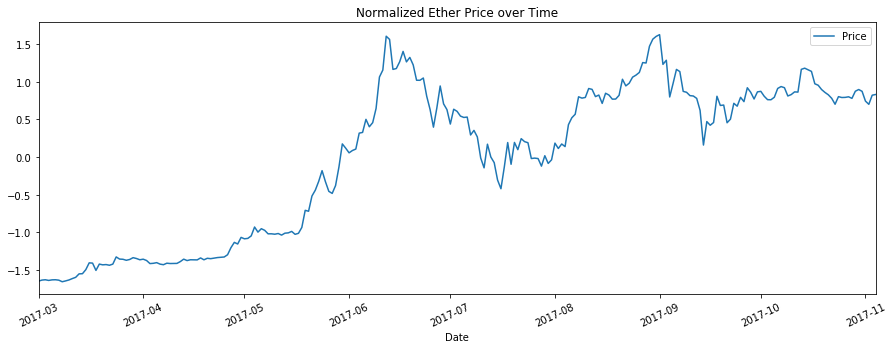

In [261]:
from sklearn.preprocessing import StandardScaler

df_no_date = df.drop('Date', axis=1)

# Standardize features by removing the mean and scaling to unit variance
scaled_no_date = StandardScaler().fit_transform(df_no_date)
scaled_df_no_date = pd.DataFrame(scaled_no_date, index=df_no_date.index, columns=df_no_date.columns)
scaled_df = pd.concat([scaled_df_no_date, X['Date'].to_frame()], axis=1)

scaled_df.plot(title='Normalized Ether Price over Time', x='Date', y='Price', rot=25, figsize=(15,5))
plt.show()
plt.close()

The price stagnates for the first 3 months, then spikes exponentially. For the remaining months, the normalized price oscillates between 0 and 1.5. The price does not hold at a high value for very long, as it dips immediately after.

AttributeError: 'AxesSubplot' object has no attribute 'show'

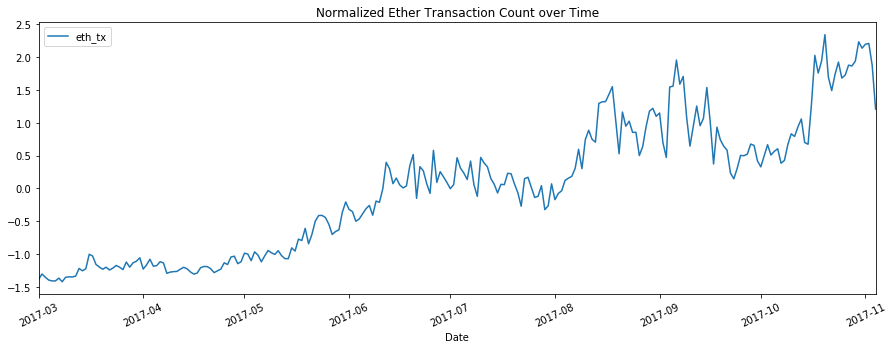

In [262]:
scaled_df.plot(title='Normalized Ether Transaction Count over Time', x='Date', y='eth_tx', rot=25, figsize=(15,5))
plt.show()
plt.close()

The ether transaction count, like price, stagnates for the first 3 months and then increases for the remaining months. It is evident that in general, as price increases, so does transaction count and as price decreases, so does transaction count.

AttributeError: 'AxesSubplot' object has no attribute 'show'

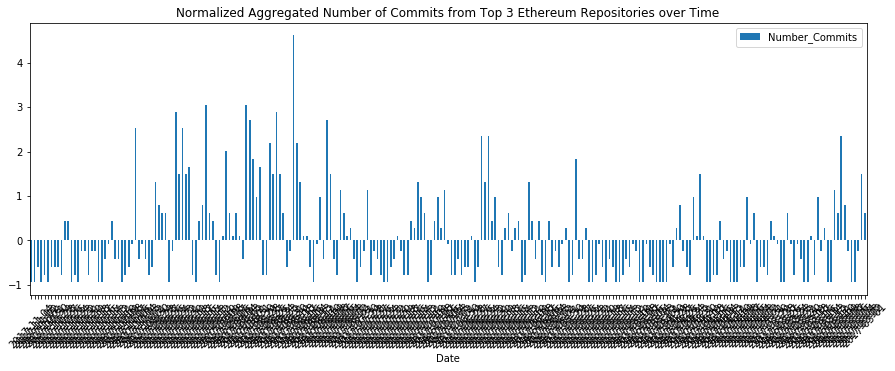

In [263]:
import matplotlib.ticker as plticker

scaled_df.plot(title='Normalized Aggregated Number of Commits from Top 3 Ethereum Repositories over Time', x='Date', y='Number_Commits', kind='bar', rot=45, figsize=(15,5))
plt.tick_params(bottom='off', labelbottom='off')
plt.show()
plt.close()

TODO: actually label with xticks, provide an explanation

## Plot the Scatter Matrix

This will display the correlation between a pair of variables. (https://www.evl.uic.edu/aej/424/kyoung/Training-scatterplot.html)

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(scaled_df_no_date, alpha=0.2, figsize=(20,20), diagonal='kde')
plt.show()
plt.close()

## Plotting Features Against Each Other

In [ ]:
df.plot(title='Ether Blocksize vs Ether Transaction Count', x='eth_blocksize', y='eth_tx', rot=25, figsize=(20,10), kind='scatter')
plt.show()
plt.close()

* As ether gas limit increases, so does ether transaction count.
* Initially, there's a general trend that as eth_difficulty increases, so does ether transaction count. However, at around eth_difficuly 1,750, eth_tx count stops increasing. With eth_difficulty greater than 1,750, there's less transactions than if the difficulty was around 1,750.

In [ ]:
df.plot(title='Ether Gas Limit vs Ether Transaction Count', x='eth_gaslimit', y='eth_tx', rot=25, figsize=(5,5), kind='scatter')
plt.show()
plt.close()

# Refer to this https://pandas.pydata.org/pandas-docs/stable/visualization.html

'''
You can see the verticle gaps correspond to the commits. 
It's a bit interesting. Not sure if the commits would influence the price though.
'''

from sklearn.preprocessing import MinMaxScaler 

X_no_date = X.drop('Date', axis=1)
scaler = MinMaxScaler() 
X_no_date.groupby(['eth_tx','eth_hashrate', 'eth_difficulty', 'eth_blocksize','eth_gasprice']).apply(lambda x: scaler.fit_transform(x))

ax = X_no_date.plot(x='eth_difficulty', y='eth_tx', rot=25, figsize=(20,10), color='r', kind='scatter')
ax = X_no_date.plot(x='eth_difficulty', y='Number_Commits', rot=25, figsize=(20,10), color='y', kind='scatter')
X_no_date.plot(x='eth_difficulty', y='eth_gasprice', rot=25, figsize=(20,10), color='b', kind='scatter', ax=ax)
plt.show()
plt.close()

df.plot(title='Ether Blocksize vs Ether Transaction Count', x='eth_difficulty', y='eth_tx', rot=25, figsize=(5,5), kind='scatter', ax = ax)
plt.show()
plt.close()

## Normalize Data before PCA

I removed the Date column, since I only wanted to consider numerical values when performing PCA

Then, I normalized the data using z-scaling to prevent certain features from dominating other features.

The explained variance ratio and the cumulative explained variance ratio in the below graph, shows that the variances slope is almost linear in logarithmic scale. Because of this, it seems that keeping 3 principal components we can explain ∼90% of the full variance. (0.658 + 0.176 + 0.077 = 0.911)

https://stats.stackexchange.com/questions/158281/can-pca-be-applied-for-time-series-data
One approach could be to take the first time differences of your 12 variables to ensure stationarity. Then calculate the 12×12 covariance matrix and perform PCA on it. This will be some sort of average PCA over the whole time span, and will not say anything about how the different timelags affect each other. But it could be a good starting point. 
	
I mean the first difference, so for each of the twelve x's I would do x_t - x_t-1

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_no_date = X.drop('Date', axis=1)
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(X_no_date)
z_data = PCA(n_components=3).fit(z_data) 

plt.semilogy(z_data.explained_variance_ratio_, '--o')
plt.semilogy(z_data.explained_variance_ratio_.cumsum(), '--o');
plt.show()
plt.close()

# explained_variance_ratio_ - Percentage of variance explained by each of the selected components.
print("Explained variance ratio:")
print(z_data.explained_variance_ratio_)

univariate ARIMA with time and price only following 
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ and 
https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/ with time series split

multivariate LSTM following https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ - no pca

Bayesian Linear Regression

# Preprocessing
* Make time series data **stationary**, removing NaN values
* TimeSeriesSplit of data

# Univariate ARIMA

## Test For Stationarity on the Time Series Data

First, I will plot time and price to see if timeseries is **stationary**. To perform univariate ARIMA, the timeseries data must be stationary. I will use the **Augmented Dickey-Fuller (ADF) Test** to test stationarity of the timeseries data. Comparing the ADF test statistic and Critical Values, specifically the value at 1%, will determine whether or not the data is stationary. The more negative the ADF test statistic, the more likely it is that one would reject the null hypothesis (i.e. the timeseries data is stationary). The criterion for how negative the ADF test statistic has to be is that it should be more negative than the ADF critical value at 1%, which would mean that there would be a high probability that the result can be taken as truth. Therefore, I want a large negative ADF test statistic, one that is less than the critical value at 1%, so that I can ensure my time series is stationary.

**I will run ADF Tests on:**
1. Original Time Series Data
2. 30 Day Moving Average of Log of Ether Price
3. Differencing - I will try to model the differences of the terms and not the actual term. For instance, **x(t) – x(t – 1)**.

Refer to: https://stats.stackexchange.com/questions/29121/intuitive-explanation-of-unit-root !!!

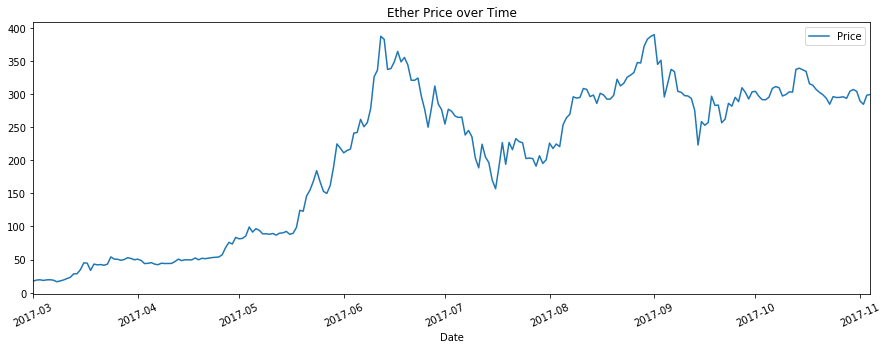

ADF ts
ADF Statistic: -0.543432
p-value: 0.883259
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [264]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

AVG_NUM_DAYS_IN_MONTH = 30

# Plot original price vs time
ts = df[['Date', 'Price']]
ts.plot(title='Ether Price over Time', x='Date', y='Price', rot=25, figsize=(15,5))
augmented_dickey_fuller = adfuller(ts['Price'])
plt.show()
plt.close()

# Print ADF Results
print('ADF ts')
print('ADF Statistic: %f' % augmented_dickey_fuller[0])
print('p-value: %f' % augmented_dickey_fuller[1])
print('Critical Values:')
for key, value in augmented_dickey_fuller[4].items():
	print('\t%s: %.3f' % (key, value))
plt.xlabel='Date (YYYY-MM)'
plt.ylabel='Ether Price (USD)'

### Running an ADF Test on the Original Time Series Data
Running an ADF test on the original time series data returns:

* **ADF Statistic:** -0.543432
* **p-value:** 0.883259
* **Critical Values:**
    1%: -3.457
	5%: -2.873
	10%: -2.573
    
The ADF test statistic is -0.543. The ADF test statistic is of -0.543 is not less than the value of -3.457 at 1%. This means that we may have a unit root (and will have to accept the null hypothesis). Our data is non-stationary, given this ADF test. In addition, the graph is also in agreement with the data being non-stationary. One can see that the mean of the data is varying over time. On average, the price of Ether is growing over time.

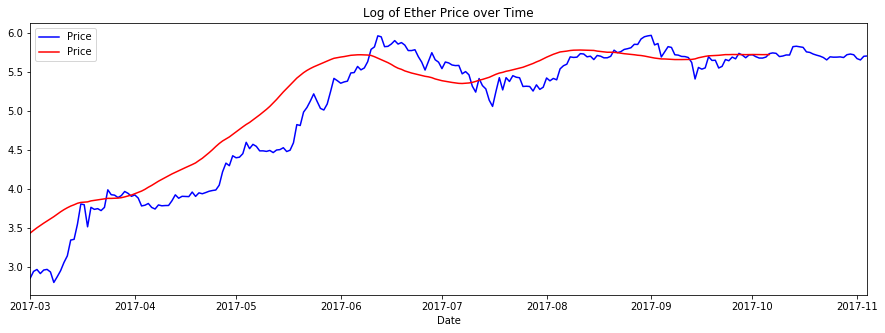

ADF moving avg difference
Moving Average Window: 30
ADF Statistic: -1.890428
p-value: 0.336577
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574


In [265]:
# Plot log of price with moving average (time window = past 30 days) vs time
ts_log = ts.copy(deep=True)
ts_log['Price'] = df['Price'].apply(np.log)
ax = ts_log.plot(title='Log of Ether Price over Time', x='Date', y='Price', rot=25, figsize=(15,5), color='blue')
moving_avg = ts_log.rolling(window=AVG_NUM_DAYS_IN_MONTH, center=False).mean()
moving_avg.plot(x='Date', y='Price', color='red', ax=ax)
plt.show()
plt.close()

ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
augmented_dickey_fuller = adfuller(ts_log_moving_avg_diff['Price'])
print('ADF moving avg difference')
print('Moving Average Window: %d' % AVG_NUM_DAYS_IN_MONTH)
print('ADF Statistic: %f' % augmented_dickey_fuller[0])
print('p-value: %f' % augmented_dickey_fuller[1])
print('Critical Values:')
for key, value in augmented_dickey_fuller[4].items():
	print('\t%s: %.3f' % (key, value))

### Running an ADF Test on 30-Day Rolling Averages of the Log of Ether Price
To make the timeseries data more stationary, I will first transform the data. I want to reduce the positive trend in Ether price. I will penalize higher values by taking the log of Ether price. This is seen in ts_log.
In addition, I want to take a moving average, i.e. I will consider only the past 30 days (one month) of Ether price data. (https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)

Running an ADF test on the transformed time series data returns:

* **ADF Test Statistic:** -1.890428
* **p-value:** 0.336577
* **Critical Values:**
	1%: -3.461
	5%: -2.875
	10%: -2.574

The ADF test statistic is -1.890. The ADF test statistic is -1.890 and is not less than the value of -3.461 at 1%. This means that we may have a unit root (and will have to accept the null hypothesis) and our data is non-stationary. More data manipulation is needed to make this time series stationary.

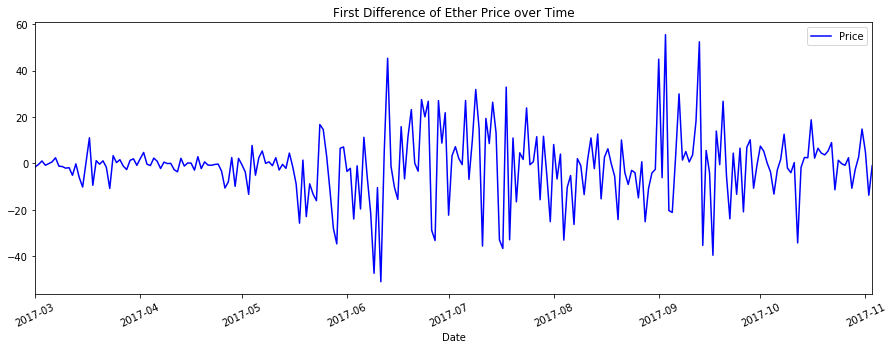

ADF First Difference
ADF Statistic: -16.188279
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [266]:
# Plot the Firsts Differences of Ether Price vs time
ts_first_differences = ts.copy(deep=True)
ts_first_differences['Price'] = ts['Price'].diff()
ts_first_differences.dropna(inplace=True)
ax = ts_first_differences.plot(title='First Difference of Ether Price over Time', x='Date', y='Price', rot=25, figsize=(15,5), color='blue')
plt.show()
plt.close()

augmented_dickey_fuller = adfuller(ts_first_differences['Price'])
print('ADF First Difference')
print('ADF Statistic: %f' % augmented_dickey_fuller[0])
print('p-value: %f' % augmented_dickey_fuller[1])
print('Critical Values:')
for key, value in augmented_dickey_fuller[4].items():
	print('\t%s: %.3f' % (key, value))

### Running an ADF Test on the First Differences of Ether Price

To make the timeseries data stationary, I will take the first difference of the Ether Price data.

Running an ADF test on the transformed time series data returns:

* **ADF Statistic:** -16.188279
* **p-value:** 0.000000
* **Critical Values:**
	1%: -3.457
	5%: -2.873
	10%: -2.573

The ADF test statistic is -16.188. The ADF test statistic is -1.890 and is a lot less than the value of -3.457 at 1%. This means that the time series data is stationary.

# Find the right parameters to be used in the ARIMA model

## AR or MA process?
I will use a **Total Correlation Chart** (also known as Auto – correlation Function / ACF). ACF is a plot of total correlation between different lag functions. 

## What order of AR or MA process?

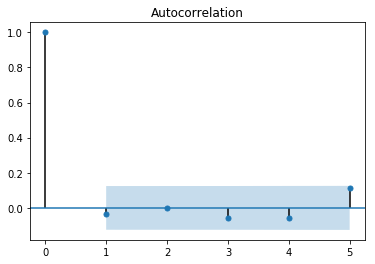

In [267]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plot_acf(x=ts_first_differences['Price'], lags=5)

This looks like a PACF plot rather than an ACF plot, since the autocorrelation does not gradually decrease. Therefore, this is not an AR series, but is a MA series. (Since an AR series would have a gradual decrease.) To find the degree of the MA series, one can look at the first occurrence of a negative autocorrelation value. The graph above shows a negative value at the 1st lag, which means this is a MA(1) process.
 
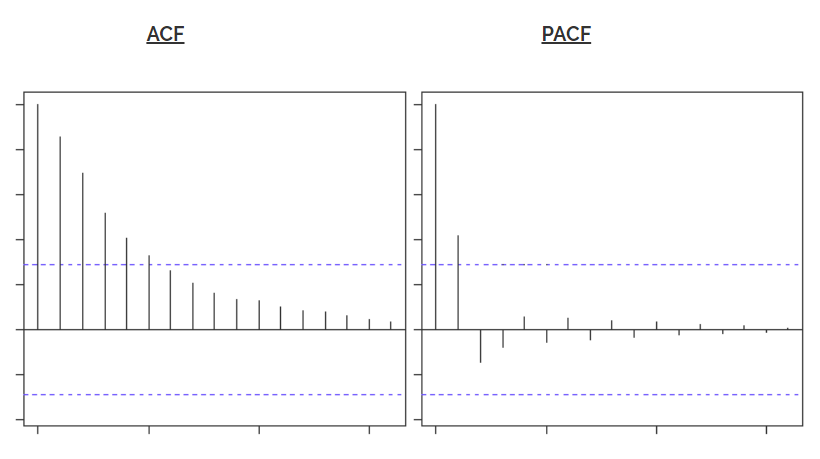
Figure from https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

# View the Ether Time Series Data

Below are the five most recent Ether price data. This data will be then split into training and testing sets.

In [268]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

# AR model of 0, difference order of 1 to make the time series stationary, MA model of 1
# timeseries index must contain dates
ts.set_index('Date').head(n=5).style

,Price
Date,
2017-11-04,299.42
2017-11-03,298.4
2017-11-02,284.61
2017-11-01,289.5
2017-10-31,304.24


# Plot of Ether Time Series Data

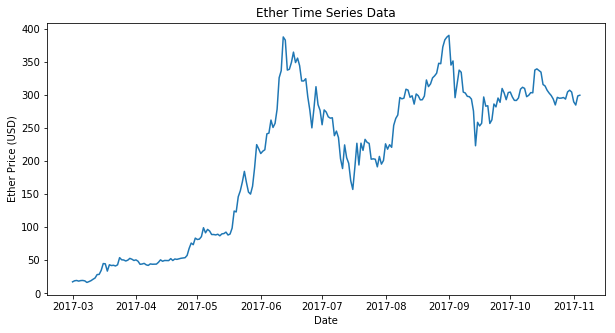

In [269]:
from matplotlib import pyplot

f, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts['Date'],ts['Price'])
ax.set_title('Ether Time Series Data')
ax.set_xlabel('Date')
ax.set_ylabel('Ether Price (USD)')
pyplot.show()

# Grid Search ARIMA Model Hyperparameters

I will evaluate a number of hyperparameters for the ARIMA model by using grid search, which will find the combination of hyperparameters that yields the lowest mean squared error. I need to find the optimal hyperparameters for ARIMA, namely (p, d, q).

* p: lag values
* d: difference iterations
* q: residual error lag values

(Taken directly from https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/ to verify my own hyperparameter selection from looking at the autocorrelation plot.)

In [270]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    print(mse)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA %s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(ts['Price'].values, p_values, d_values, q_values)

32974.4414427
ARIMA(0, 0, 0) MSE=32974.441
9589.83601947
ARIMA(0, 0, 1) MSE=9589.836
37.3983889223
ARIMA(0, 1, 0) MSE=37.398
37.882252461
ARIMA(0, 1, 1) MSE=37.882
38.1494084694
ARIMA(0, 1, 2) MSE=38.149
68.9936707729
ARIMA(0, 2, 0) MSE=68.994
38.7265471256
ARIMA(0, 2, 1) MSE=38.727
39.2741102688
ARIMA(0, 2, 2) MSE=39.274
59.7960423394
ARIMA(1, 0, 0) MSE=59.796
59.5956903929
ARIMA(1, 0, 1) MSE=59.596
60.1097501865
ARIMA(1, 0, 2) MSE=60.110
37.8522614885
ARIMA(1, 1, 0) MSE=37.852
38.1903129606
ARIMA(1, 1, 1) MSE=38.190
50.218949944
ARIMA(1, 2, 0) MSE=50.219
39.2471792184
ARIMA(1, 2, 1) MSE=39.247
39.1483087729
ARIMA(1, 2, 2) MSE=39.148
59.5973526265
ARIMA(2, 0, 0) MSE=59.597
38.0381297609
ARIMA(2, 1, 0) MSE=38.038
46.5625823991
ARIMA(2, 2, 0) MSE=46.563
39.3914204677
ARIMA(2, 2, 1) MSE=39.391
Best ARIMA (0, 1, 0) MSE=37.398


The best hyperparameters are (0,1,0) with a 37.398 mean squared error. These hyper parameters have the lowest MSE. By viewing the autocorrelation plot, I had predicted (0,1,1) as the hyperparameters. This also has a low MSE of 37.882, so I was not far off.

# Perform a Rolling Forcast with Univariate ARIMA Models

`TimeSeriesSplit` will be used to create a `time series cross validator` called splits. This cross validator will be used to provide multiple training and testing splits of the ether price data. Then, perform a rolling forcast with a univariate ARIMA model, i.e. for each new observation, create a new ARIMA model. Finally, make a new prediction for each each model.

(Adapted from  https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)

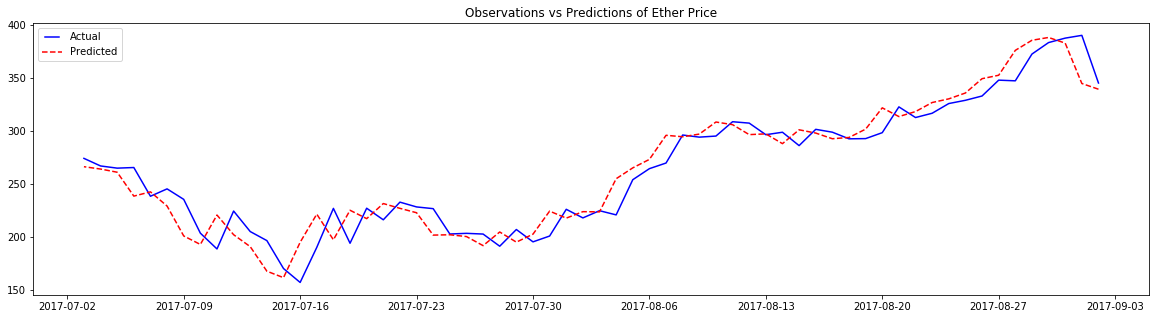

Test MSE: 298.727
Test RMSE: 17.284


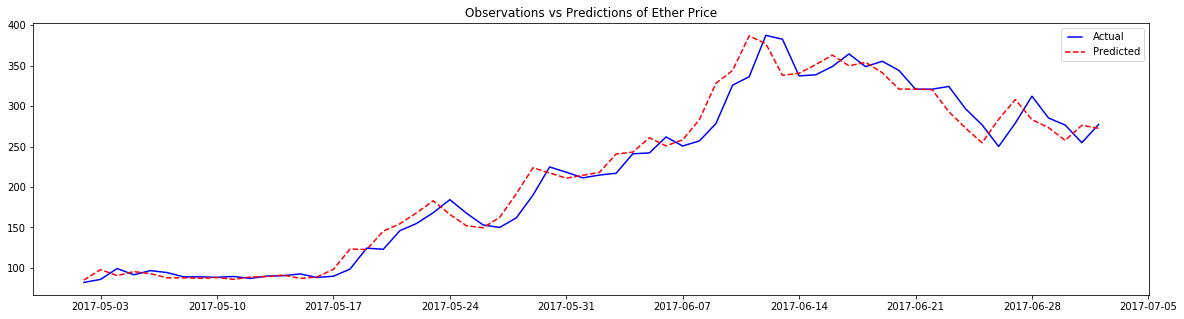

Test MSE: 344.359
Test RMSE: 18.557


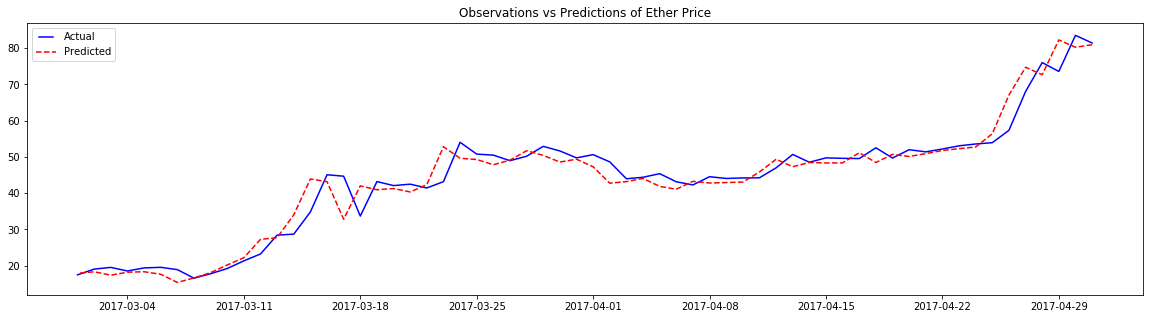

Test MSE: 14.173
Test RMSE: 3.765


In [271]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.model_selection import TimeSeriesSplit
from matplotlib.legend_handler import HandlerLine2D
from math import sqrt

splits = TimeSeriesSplit(n_splits=3)

for train_indices, test_indices in splits.split(ts):
    train = ts.iloc[train_indices]
    test = ts.iloc[test_indices]
            
    # Drop NaN
    train = train.dropna()
            
    # Historical Ether prices
    history = [x for x in train['Price']]
    
    # Rolling forecast with the ARIMA model - make a new model for each new observation
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(0,1,1))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast() # To predict 7 steps out, set steps = 7 
        yhat = output[0][0]
        predictions.append(yhat)
        obs = test.iloc[t]['Price']
        history.append(obs)
        # print('predicted=%f, expected=%f' % (yhat, obs))
    
    fig, ax = pyplot.subplots(figsize=(20, 5))
    ax.set_title('Observations vs Predictions of Ether Price')
    line1, = ax.plot(test['Date'],test['Price'], 'b', label='Actual')
    line2, = ax.plot(test['Date'], predictions, 'r--', label='Predicted')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
    pyplot.show()
        
    mse = mean_squared_error(test['Price'].values, predictions)  
    rmse = sqrt(mean_squared_error(test['Price'].values, predictions))
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)

Make a prediction of Ether price 7 days into the future. Do rolling forecast like above...this one stinks :(

In [277]:
import numpy as np

# Train on 80% of the data and test on 20%
print('total data points: ', len(ts))

ts_reversed = ts.copy(deep=True).iloc[::-1] # reverse the dataframe to predict in the future
train_index = int(len(ts) * .8)
train = ts_reversed[0:train_index]
test = ts_reversed[train_index:len(ts) - 1]
model = ARIMA(train['Price'], order=(0,1,1))
model_fit = model.fit(disp=0)
forecast = model_fit.forecast(steps=7) # To predict 7 steps out, set steps = 7 

# invert the differenced forecast to something usable
print(forecast[0])

last_train_price = train.iloc[len(train) - 1]['Price']
next_seven_test_prices = test.iloc[np.arange(len(test)-8,len(test)-1)].values.flatten()
print('Last training price:\n', last_train_price)
print('Next 7 testing prices:\n', next_seven_test_prices)

total data points:  249


ValueError: Given a pandas object and the index does not contain dates

The residuals are difference between the actual and predicted values. The residual plot should look random around 0 and do not show any trend, so this means that there aren't any missing trends or elements in the ARIMA model.

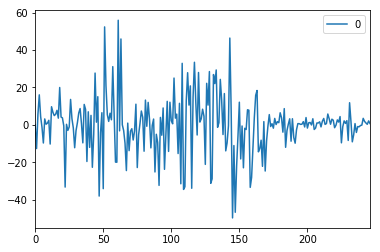

In [274]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

This is the density plot of the residual error values. The errors look like they are in a Gaussian distribution, and are centered at 0. The mean is around 0, so this suggests that there is not much bias in the prediction. 

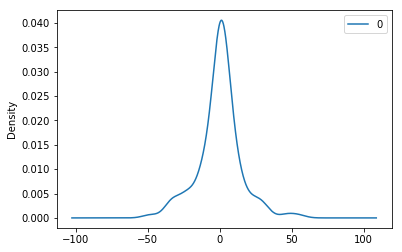

                0
count  247.000000
mean    -0.000029
std     15.018872
min    -49.721903
25%     -5.189585
50%      0.737297
75%      5.551066
max     55.942664


In [275]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

This is an autocorrelation plot. Autocorrelation determines the amount of the relationship between a current observation and previous observations. There is not an obvious autocorrelation trend in the plot. There might be some positive autocorrelation at around lag 20 that seems significant. Autocorrelations for data values at varying time lags. It seems that earlier lags have larger autocorrelation. This makes sense, because the first few months of Ether price data showed generally low Ether price data with low variation in price. Thus, there is a bit of a relationship between early Ether price timeseries data points. However, in later months, Ether price data was a lot more random, so the autocorrelations for later timeseries data is closer to 0 than the autocorrelations in earlier months which were much larger in magnitude.

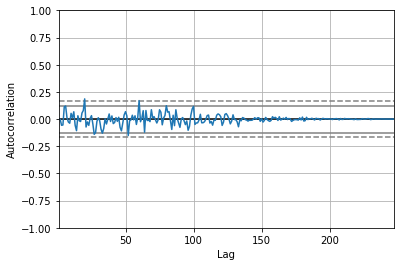

In [276]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(residuals)

# Training

* Train with Bayesian Linear Regression classifier

# Testing

* Test it and confirm with the mean squared error

# Optimizing 

* Do I need more data points for the prediction to get better? - graph it
* Should I try using another model?